In [1]:
!pip install -U tensorflow_datasets


Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.7/dist-packages (4.2.0)


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar

import math
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
dataset, metadata = tfds.load("fashion_mnist", as_supervised = True, with_info=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

In [6]:
class_names = metadata.features["label"].names
print("class names:", class_names)

class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
print("Number of train Examples:{}".format(metadata.splits['train'].num_examples))
print("Number of test Examples:{}".format(metadata.splits['test'].num_examples))

Number of train Examples:60000
Number of test Examples:10000


In [11]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [12]:
for img, label in test_dataset.take(1):
  break
image = img.numpy().reshape((28,28))

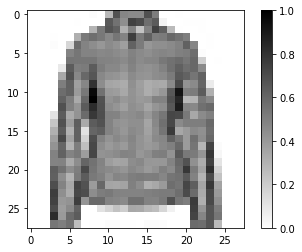

In [13]:
plt.figure()
plt.imshow(image,cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

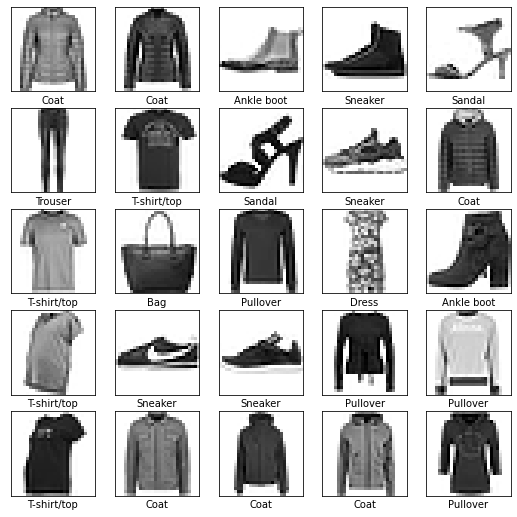

In [14]:
plt.figure(figsize=(9,9))
for i, (image, label) in enumerate(test_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

In [15]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape = (28,28,1)),
                             tf.keras.layers.Dense(128, activation = tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

In [18]:
Batch_size = 32
train_dataset = train_dataset.cache().repeat().shuffle(metadata.splits['train'].num_examples).batch(Batch_size)
test_dataset = test_dataset.cache().batch(Batch_size)

In [19]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(metadata.splits['train'].num_examples/Batch_size))

Epoch 1/5
1875/1875 [==============================] - 8s 2ms/step - loss: 0.6166 - accuracy: 0.7871
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3817 - accuracy: 0.8635
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3418 - accuracy: 0.8770
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3204 - accuracy: 0.8836
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2986 - accuracy: 0.8909


In [20]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps= math.ceil(metadata.splits['test'].num_examples/32))
print("Accuracy on test dataset:", test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.3900 - accuracy: 0.8616
Accuracy on test dataset: 0.8615999817848206


In [21]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [22]:
predictions.shape

(32, 10)

In [23]:
np.argmax(predictions[0])

4

In [24]:
test_labels[0]

4

In [25]:
def plot_image(i, predictions, true_labels, images):
  prediction, true_label, image = predictions[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image.reshape((28,28)),cmap=plt.cm.binary)
  predicted_label = np.argmax(prediction)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],100*np.max(prediction),class_names[true_label]),color=color)
 
def plot_value_array(i, predictions, true_label):
  prediction, true_label = predictions[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), prediction, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(prediction)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

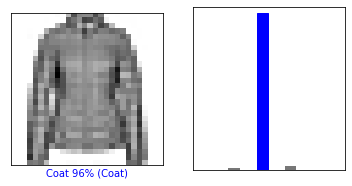

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

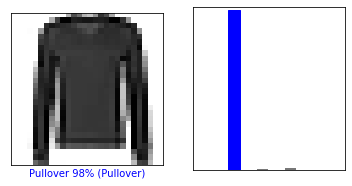

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

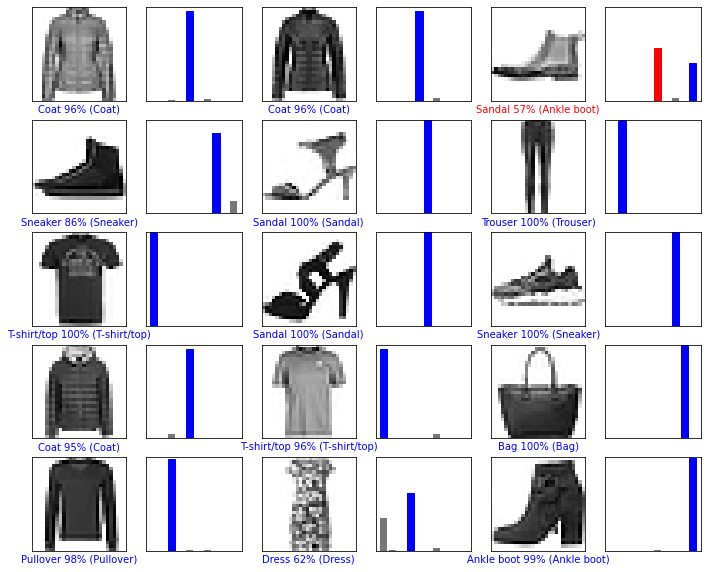

In [28]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Experimenting:
- Set epoch to 1 => Model doesn't converge
-Don't normalize pixel values => loss starts at a very high value and reached a max accuracy of ~84%
-Vary number of neurons in Dense layer => 
10 neurons (Peaked at an accuracy of about ~87% after 5 epocs )
512 neurons (Not much differnt from 128, just a lot more parameters to train so better to use 128)
-Additional layers => Performance is very similar to the original model.